# Machine Learning - Autoregression Models for Time Series Forecasting

In this notebook, we are going to explore a couple of diffrent machine learning models to predict time-series data.

Here is a link to all articles/tutorials:
 - [Time Series Archive](http://machinelearningmastery.com/category/time-series/)
 
Here are links to specific articles:
 - [How to Make Out-of-Sample Forecasts with ARIMA in Python](http://machinelearningmastery.com/make-sample-forecasts-arima-python/)
 - [Sensitivity Analysis of History Size to Forecast Skill with ARIMA in Python](http://machinelearningmastery.com/sensitivity-analysis-history-size-forecast-skill-arima-python/)
 - [Feature Selection for Time Series Forecasting with Python](http://machinelearningmastery.com/feature-selection-time-series-forecasting-python/)
 - [Simple Time Series Forecasting Models to Test So That You Don’t Fool Yourself](http://machinelearningmastery.com/simple-time-series-forecasting-models/)
 - [Autoregression Models for Time Series Forecasting With Python](http://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

## Autoregression Models for Time Series Forecasting

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

We will be modeling an output variable based on a linear combination of input variables. Predictions for future values in a sequence are generated based on a certain window of previous values. This window shifts forward to make predictions further and further into the future.

In [1]:
import pandas as pd
import numpy as np

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

from plotly.graph_objs import *

In [2]:
# load dataset
data = pd.read_csv('data/slo_weather_history.csv', index_col=0)

# display first few rows
data.head()

,dew_point_f_avg,dew_point_f_high,dew_point_f_low,events,humidity_%_avg,humidity_%_high,humidity_%_low,precip_in_sum,sea_level_press_in_avg,sea_level_press_in_high,sea_level_press_in_low,temp_f_avg,temp_f_high,temp_f_low,visibility_mi_avg,visibility_mi_high,visibility_mi_low,wind_gust_mph_high,wind_mph_avg,wind_mph_high
date,,,,,,,,,,,,,,,,,,,,
2012-1-1,44.0,50.0,34.0,Fog,80.0,100.0,25.0,0.00,30.15,30.23,30.08,56.0,73.0,39.0,6.0,10.0,0.0,0.0,1.0,8.0
2012-1-2,47.0,52.0,43.0,Fog,93.0,100.0,63.0,0.00,30.23,30.30,30.19,52.0,63.0,42.0,4.0,10.0,0.0,0.0,3.0,14.0
2012-1-3,43.0,50.0,37.0,Fog,85.0,100.0,32.0,0.01,30.24,30.28,30.17,58.0,77.0,39.0,6.0,10.0,0.0,0.0,2.0,10.0
2012-1-4,42.0,47.0,37.0,,69.0,96.0,33.0,0.00,30.24,30.30,30.20,56.0,73.0,39.0,10.0,10.0,8.0,0.0,1.0,9.0
2012-1-5,42.0,51.0,36.0,,66.0,93.0,23.0,0.00,30.15,30.22,30.09,60.0,78.0,42.0,10.0,10.0,7.0,22.0,4.0,18.0


In [3]:
def plot_helper(x, traces, trace_name, title):
    data = []
    
    for i, trace in enumerate(traces):
        # prepare data for plot
        data.append(
            Scatter(x=np.array(x),
                    y=trace,
                    name=trace_name[i])
        )

    layout = Layout({
        'title': title
        }
    )
    
    # plot scores over persistence values
    fig = Figure(data=data, layout=layout)
    py.iplot(fig)

### Quick Check for Autocorrelation

An autoregression model assumes that recent values are relevant to predicting the next value in a sequence. If these input variables are indeed instrumental in determining the output variable, the variables are said to have high correlation. The graph below suggests a relationship is present.

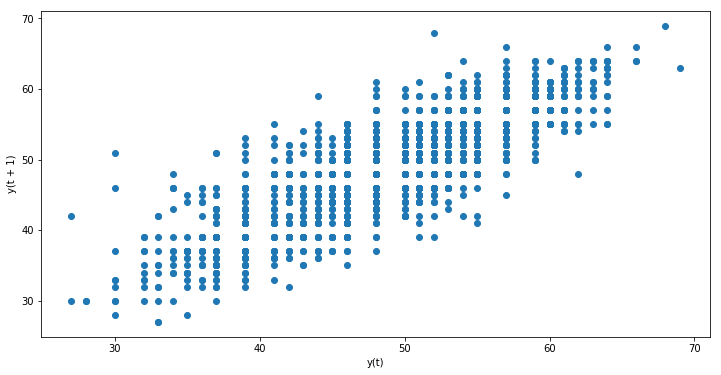

In [4]:
plt.figure(num=None, figsize=(12, 6))
lag_plot(data['temp_f_low'])
plt.show()

In [5]:
df = pd.concat([data['temp_f_low'].shift(1), data['temp_f_low']], axis=1)
df.columns = ['t-1', 't+1']
result = df.corr()

result

,t-1,t+1
t-1,1.000000,0.827876
t+1,0.827876,1.000000


This chart generates the same conclusion, as the correlation coefficient suggests a strong positive linear relationship.

### Autocorrelation Plots

Autocorrelation plots show the correlation coefficients for each "lag" variable. The dashed lines represent 95% and 99% confidence intervals.

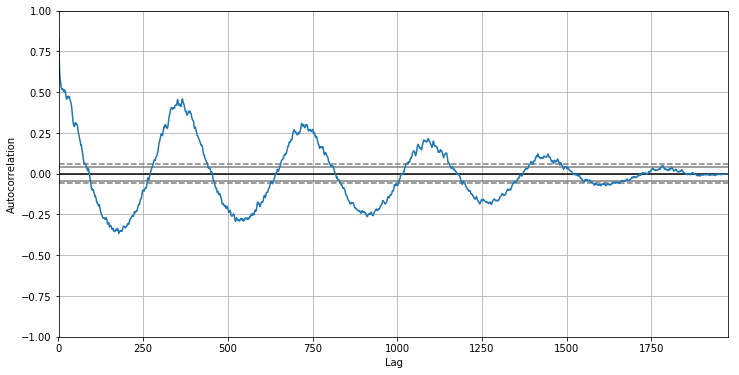

In [6]:
plt.figure(num=None, figsize=(12, 6))
autocorrelation_plot(data['temp_f_low'])
plt.show()

It makes sense that the correlations would swing between positive and negative values, as the temperatures shift between seasons over the years.

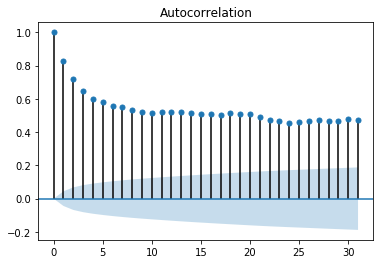

In [7]:
plt.figure(num=None, figsize=(12, 6))
plot_acf(data['temp_f_low'], lags=31)
plt.show()

### Autoregression Model
#### Fixed AR Model

The statsmodels library provides an autoregression model that automatically selects an approprite lag value and trains a linear regression model - this should generate a superior model to scikit-learn's linear regression model, which requires us to specify ahead of time which variables to include in the model.

In [12]:
# split into train and test sets
X = data['temp_f_low'].values

train, test = X[1:len(X) - 7], X[len(X) - 7:]

In [13]:
# train autoregression
model = AR(train)
model_fit = model.fit()

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 25
Coefficients: [  2.69113832e+00   6.76535679e-01   8.33505352e-03   2.34633082e-02
  -1.92289500e-02   6.49388665e-02  -1.93464232e-02   4.35407817e-02
  -2.07799429e-02   1.42483914e-02  -5.13330412e-03   5.51131468e-02
  -3.91629730e-03   2.46577053e-02  -5.57516104e-03   9.05781894e-03
   3.92788546e-02  -4.76940790e-02   8.01136510e-02  -2.04711469e-02
   3.98518674e-02  -1.25816581e-03  -1.70186794e-02   8.41351825e-03
  -2.88694521e-02   4.81265624e-02]


In [14]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

for i in range(len(predictions)):
    print('Day %d -- Forecast: %f, Actual: %f' % (i + 1, predictions[i], test[i]))

error = np.sqrt(mean_squared_error(test, predictions))
print('\nTest RMSE: %.3f' % error)

Day 1 -- Forecast: 52.116721, Actual: 57.000000
Day 2 -- Forecast: 51.344425, Actual: 54.000000
Day 3 -- Forecast: 51.397121, Actual: 48.000000
Day 4 -- Forecast: 51.601338, Actual: 53.000000
Day 5 -- Forecast: 51.568685, Actual: 53.000000
Day 6 -- Forecast: 51.614797, Actual: 52.000000
Day 7 -- Forecast: 51.461988, Actual: 51.000000

Test RMSE: 2.586


In [15]:
# plot results
plot_helper(df[len(X) - 7:].index, [test, predictions], ['Test', 'Forecast'], 'Predictions From Fixed AR Model')

#### Rolling AR Model

In [16]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [17]:
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('Day %d -- Forecast: %f, Actual: %f' % (t + 1, yhat, obs))

error = np.sqrt(mean_squared_error(test, predictions))
print('\nTest RMSE: %.3f' % error)

Day 1 -- Forecast: 52.116721, Actual: 57.000000
Day 2 -- Forecast: 54.648137, Actual: 54.000000
Day 3 -- Forecast: 53.234415, Actual: 48.000000
Day 4 -- Forecast: 49.439777, Actual: 53.000000
Day 5 -- Forecast: 52.455022, Actual: 53.000000
Day 6 -- Forecast: 52.781134, Actual: 52.000000
Day 7 -- Forecast: 51.910638, Actual: 51.000000

Test RMSE: 3.072


In [18]:
# plot
plot_helper(df[len(X) - 7:].index, [test, predictions], ['Test', 'Forecast'], 'Predictions From Rolling AR Model')